In [4]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
import pickle
import mlflow
import pandas as pd
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [84]:
def prepare_the_data(url):
    df = pd.read_parquet(url)

    # Convert into minutes
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration_minutes'] = df['duration'].dt.total_seconds() / 60

    # Filder df by trip time
    df = df[(df['duration_minutes'] >= 1) & (df['duration_minutes'] <= 60)]

    # Features defining
    categorical_features = ['PULocationID', 'DOLocationID']
    
    # Data Type preparation
    df[categorical_features] = df[categorical_features].astype(str)

    return df[:10000]

In [85]:
def extract_features(df, dv=None):
    features = df[['PULocationID', 'DOLocationID']]
    features_dict = features.to_dict(orient="records")
    
    if dv is None:  # Fit on training data
        dv = DictVectorizer(sparse=False)
        X = dv.fit_transform(features_dict)
        return X, dv
    else:  # Transform validation data
        X = dv.transform(features_dict)
        return X


In [86]:
df_train = prepare_the_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet')
X_train, dv = extract_features(df_train)
train_y_true = df_train['duration_minutes']

In [87]:
df_valid = prepare_the_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet')
X_valid = extract_features(df_valid, dv=dv)
valid_y_true = df_valid['duration_minutes']

In [88]:
df_train.shape == df_valid.shape

True

In [89]:
X_train.shape, X_valid.shape

((10000, 303), (10000, 303))

In [90]:
train = xgb.DMatrix(X_train, label = train_y_true)
valid = xgb.DMatrix(X_valid, label = valid_y_true)

In [91]:
df_train.columns == df_valid.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [92]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("nyc-taxi-tracking")

<Experiment: artifact_location='mlflow-artifacts:/229660854558557635', creation_time=1738090447414, experiment_id='229660854558557635', last_update_time=1738090447414, lifecycle_stage='active', name='nyc-taxi-tracking', tags={}>

In [93]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        
        # Train the model using the hyperparameters
        booster = xgb.train(
            params=params, 
            dtrain=train, 
            num_boost_round=1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 10,
            verbose_eval=False
        )
            
        # Predict and evaluate RMSE
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(valid_y_true, y_pred)
        mlflow.log_metric('rmse', rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [94]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 50, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'alpha': hp.loguniform('alpha', -5, -1),
    'lambda': hp.loguniform('lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}
best_result = fmin(
    fn=objective, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=Trials())


🏃 View run amusing-mole-457 at: http://127.0.0.1:5000/#/experiments/229660854558557635/runs/976b39594e4642afbe5f1c2bbb78be52

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229660854558557635   

🏃 View run sedate-carp-984 at: http://127.0.0.1:5000/#/experiments/229660854558557635/runs/26881cfcf61a43b685b158a2b5b25660

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229660854558557635   

🏃 View run bedecked-goat-351 at: http://127.0.0.1:5000/#/experiments/229660854558557635/runs/737ea1a742f346e0bc58223e29295628

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229660854558557635   

🏃 View run nimble-stoat-186 at: http://127.0.0.1:5000/#/experiments/229660854558557635/runs/9fb32f689b874c6c9f829a7b1a3f666d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229660854558557635   

🏃 View run learned-steed-300 at: http://127.0.0.1:5000/#/experiments/229660854558557635/runs/529b71d603684d9489090640da1e9b70

🧪 View experiment at: http://127.0.0.1:5000/#

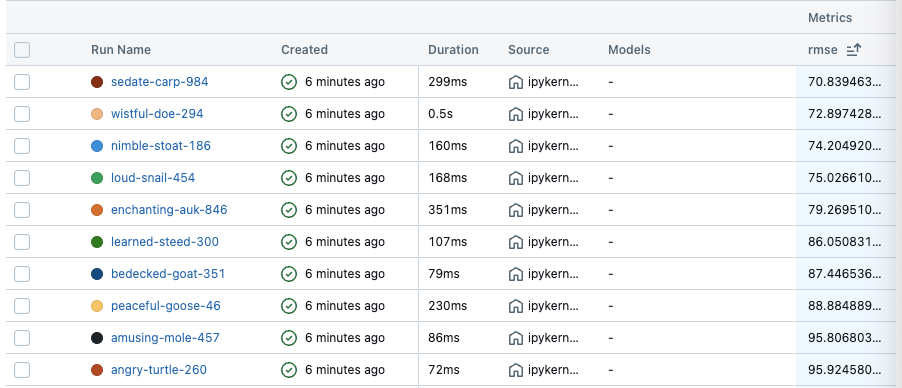